In [1]:
import numpy as np
import itertools
import math
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def kendall_tau_distance(order_a, order_b):
    pairs = itertools.combinations(range(1, len(order_a)+1), 2)
    distance = 0
    for x, y in pairs:
        a = order_a.index(x) - order_a.index(y)
        b = order_b.index(x) - order_b.index(y)
        if a * b < 0:
            distance += 1
    return distance

def pseudo_dist(X, tk):
    return np.sqrt(np.linalg.norm(X[i,:tk]-X[j,:tk])**2 - np.linalg.norm(X[i,tk:]-X[j,tk:])**2)


In [3]:
def pseudo_embedding(D, dim=0):
    n = D.shape[0]
    
    bilin_form = np.zeros((n-1, n-1))
    for i in range(1,n):
        for j in range(1,n):
             bilin_form[i-1,j-1] = 1/2 * (D[0,i]+ D[0,j]- D[i,j])
    w, v = np.linalg.eigh(bilin_form)
    w = np.real(w)

    idx_pos = np.argwhere((w > 0) & (w > 10e-12)).flatten()
    idx_neg = np.argwhere((w < 0) & (w < -10e-12)).flatten()
    idx_zero = np.argwhere((10e-12 >= w) & (-10e-12 <= w)).flatten()
    idx = np.concatenate([idx_pos, idx_neg])
    
    w = w[idx]
    # should be refactored
    idx_pos = np.argwhere((w > 0) & (w > 10e-12)).flatten()
    idx_neg = np.argwhere((w < 0) & (w < -10e-12)).flatten()
    v = v[:,idx]
    
    w_abs = np.abs(w)
    if dim != 0: # take some smaller number of dimensons than all
        idx_sorted = w_abs.argsort()[::-1]
        idx_top = idx_sorted[:dim]
        idx_pos = np.intersect1d(idx_top, idx_pos)
        idx_neg = np.intersect1d(idx_top, idx_neg)

    pdim, ndim = len(idx_pos), len(idx_neg)

    X = v[:, :pdim+ndim] @ np.sqrt(np.abs(np.diag(w[:pdim+ndim])))
    return np.concatenate((np.expand_dims(np.zeros(pdim+ndim), axis=0), X), axis=0), pdim

[8.77473555e-01 8.49393113e-01 8.32393390e-01 7.47079005e-01
 7.27781414e-01 6.89520357e-01 6.61446349e-01 6.29218810e-01
 6.02543590e-01 5.75333163e-01 5.51126222e-01 5.24940951e-01
 4.10523726e-01 3.24550142e-01 2.17075618e-01 2.69053916e-02
 1.97389473e-02 1.25497731e-02 5.10422634e-03 2.64515041e-16]


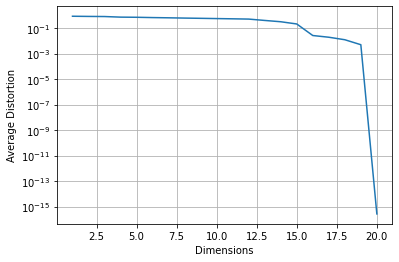

In [4]:
T = nx.balanced_tree(4,2)
D_tree = nx.floyd_warshall_numpy(T)
'''
# larger experiment on cs phd dataset
Go = nx.read_edgelist("data/csphd.txt", nodetype = int)
G = max(nx.connected_components(G), key=len)
#D_tree = nx.floyd_warshall_numpy(G)
'''

D = D_tree**2
n = D_tree.shape[0]
err = np.zeros(n-1)

for dim in range(1,n):
    X, tk = pseudo_embedding(D, dim=dim)
    rec = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            rec[i,j] = np.abs(np.linalg.norm(X[i,:tk]-X[j,:tk])**2 - np.linalg.norm(X[i,tk:]-X[j,tk:])**2)
            if i != j:
                err[dim-1] += np.abs((np.sqrt(D[i,j])-np.sqrt(rec[i,j])))/np.sqrt(D[i,j])
                #err += np.abs((np.sqrt(D[i,j])-np.sqrt(rec[i,j])))/np.sqrt(D[i,j])
    err[dim-1]/= (n*(n-1))
    #err/= (n*(n-1))

print(err)
plt.semilogy(list(range(1,n)), err)
plt.xlabel('Dimensions')
plt.ylabel('Average Distortion')
plt.grid()


### Version for permutations

In [5]:
permlen = 4
n = math.factorial(permlen)
e = list(range(1,permlen+1))
i, j = 0,0
D = np.zeros((n, n))

for a in itertools.permutations(e):
    for b in itertools.permutations(e):
        D[i,j] = kendall_tau_distance(a,b)**2
        j += 1
    i += 1
    j = 0


X, tk = pseudo_embedding(D, dim=0)
rec = np.zeros((n, n))
err = 0
for i in range(n):
    for j in range(n):
        rec[i,j] = np.abs(np.linalg.norm(X[i,:tk]-X[j,:tk])**2 - np.linalg.norm(X[i,tk:]-X[j,tk:])**2)
        if i != j:
            err += np.abs((np.sqrt(D[i,j])-np.sqrt(rec[i,j])))/np.sqrt(D[i,j])
err /= (n*(n-1))


### Version for Spearman's Footrule

In [6]:
permlen = 4
n = math.factorial(permlen)
e = list(range(1,permlen+1))
i, j = 0,0
D = np.zeros((n, n))

for a in itertools.permutations(e):
    for b in itertools.permutations(e):
        D[i,j] = np.sum(np.abs(np.array(a)-np.array(b)))**2
        j += 1
    i += 1
    j = 0


X, tk = pseudo_embedding(D, dim=0)
rec = np.zeros((n, n))
err = 0
for i in range(n):
    for j in range(n):
        rec[i,j] = np.abs(np.linalg.norm(X[i,:tk]-X[j,:tk])**2 - np.linalg.norm(X[i,tk:]-X[j,tk:])**2)
        if i != j:
            err += np.abs((np.sqrt(D[i,j])-np.sqrt(rec[i,j])))/np.sqrt(D[i,j])
err /= (n*(n-1))
print(f"Reconstruction error ={err}")


Reconstruction error =1.239749044164757e-15


### Now let's see how our embeddings help us recover distances 
We want to try to use the implicit version of the recovery algorithm

In [7]:
# Utilities
def compute_partition_func(center, theta):
    rho = len(center)
    e = list(range(1,rho+1))
    all_vectors = list(itertools.permutations(e))
    
    Z = 0 
    for vec in all_vectors:
        Z += np.exp(- theta * kendall_tau_distance(center, vec))

    return Z

def compute(x, center, theta, Z):
    return np.exp(-theta * kendall_tau_distance(center, x)) / Z

rho = 3
n = math.factorial(rho)
i, j = 0,0
D = np.zeros((n, n))
e = list(range(1,rho+1))

for a in itertools.permutations(e):
    for b in itertools.permutations(e):
        D[i,j] = kendall_tau_distance(a,b)**2
        j += 1
    i += 1
    j = 0

X, tk = pseudo_embedding(D, dim=0)

center = list(range(1,rho+1))
theta1, theta2 = 1.0, 2.0

Z1 = compute_partition_func(center, theta1)
Z2 = compute_partition_func(center, theta2)

all_vectors = list(itertools.permutations(center))
probs1, probs2 = {}, {}
tot_p = 0
# print the probabilities
print(f"Probabilities of the permutations")
for vec in all_vectors:
    p1 = compute(vec, center, theta1, Z1)
    print(f"perm = {vec}, prob = {p1}")
    p2 = compute(vec, center, theta2, Z2)
    probs1[vec] = p1
    probs2[vec] = p2
    tot_p += p1
print(f"{tot_p}\n")

# compute average distances:
dist1, dist2 = 0, 0
for vec in all_vectors:
    dist1 += kendall_tau_distance(vec, center) * probs1[vec]
    dist2 += kendall_tau_distance(vec, center) * probs2[vec]

print(f"Avg dist to center {center} with theta = {theta1} is {dist1}")
print(f"Avg dist to center {center} with theta = {theta2} is {dist2}")


Probabilities of the permutations
perm = (1, 2, 3), prob = 0.4863301075752071
perm = (1, 3, 2), prob = 0.17891084819961464
perm = (2, 1, 3), prob = 0.17891084819961464
perm = (2, 3, 1), prob = 0.06581762285518299
perm = (3, 1, 2), prob = 0.06581762285518299
perm = (3, 2, 1), prob = 0.024212950315197466
0.9999999999999999

Avg dist to center [1, 2, 3] with theta = 1.0 is 0.6937310387655536
Avg dist to center [1, 2, 3] with theta = 2.0 is 0.2682658298012494


In [8]:
# now we wanna try to see if we can use the embeddings
#   to recover the average distances
#y1 = [1,2,3]
y1, y2, y1id, y2id = [1,3,2], [1,3,2], 1, 1
#y2 = [1,2,3]
#y2 = [3,1,2]
#y1id, y2id = 0, 0
#y1id, y2id = 1, 4

print(f"centers are")
print(f"y1 = {y1} and emb {X[y1id]}")
print(f"y2 = {y2} and emb {X[y2id]}\n")

probs1y1, probs1y2, probs2y1, probs2y2 = {}, {}, {}, {}
Z1y1 = compute_partition_func(y1, theta1)
Z2y1 = compute_partition_func(y1, theta2)
Z1y2 = compute_partition_func(y2, theta1)
Z2y2 = compute_partition_func(y2, theta2)
for vec in all_vectors:
    probs1y1[vec] = compute(vec, y1, theta1, Z1y1)
    probs2y1[vec] = compute(vec, y1, theta2, Z2y1)
    probs1y2[vec] = compute(vec, y2, theta1, Z1y2)
    probs2y2[vec] = compute(vec, y2, theta2, Z2y2)
    
# need the following terms:
# for each i, E[(g(lambda)_i-g(center)_i)]
# need a lookup too...
n, k = X.shape
vals1 = np.zeros(k)
vals2 = np.zeros(k)
idx = 0
d1y, d2y, d1d2 = 0, 0, 0
# verify
d1yc, d2yc, d1d2c, d1d2c2 = 0, 0, 0, 0

for vec in all_vectors:
    d1y += 0.5 * kendall_tau_distance(vec, y1)**2 * probs1y1[vec] + 0.5 * kendall_tau_distance(vec, y2)**2 * probs1y2[vec]
    d2y += 0.5 * kendall_tau_distance(vec, y1)**2 * probs2y1[vec] + 0.5 * kendall_tau_distance(vec, y2)**2 * probs2y2[vec]
    d1yc += 0.5 * (np.sum((X[idx,:tk]-X[y1id,:tk])**2) - np.sum((X[idx,tk:]-X[y1id,tk:])**2)) * probs1y1[vec]
    d1yc += 0.5 * (np.sum((X[idx,:tk]-X[y2id,:tk])**2) - np.sum((X[idx,tk:]-X[y2id,tk:])**2)) * probs1y2[vec]

    d2yc += 0.5 * (np.linalg.norm(X[idx,:tk]-X[y1id,:tk])**2 - np.linalg.norm(X[idx,tk:]-X[y1id,tk:])**2) * probs2y1[vec]
    d2yc += 0.5 * (np.linalg.norm(X[idx,:tk]-X[y2id,:tk])**2 - np.linalg.norm(X[idx,tk:]-X[y2id,tk:])**2) * probs2y2[vec]

    idx += 1

idx, idx2 = 0, 0
for vec1 in all_vectors:
    for vec2 in all_vectors:
        d1d2 += 0.5 * kendall_tau_distance(vec1, vec2)**2 * probs1y1[vec1] * probs2y1[vec2]
        d1d2 += 0.5 * kendall_tau_distance(vec1, vec2)**2 * probs1y2[vec1] * probs2y2[vec2]
        d1d2c += 0.5 * (np.linalg.norm(X[idx,:tk]-X[idx2,:tk])**2 - np.linalg.norm(X[idx,tk:]-X[idx2,tk:])**2) * probs1y1[vec1] * probs2y1[vec2]
        d1d2c += 0.5 * (np.linalg.norm(X[idx,:tk]-X[idx2,:tk])**2 - np.linalg.norm(X[idx,tk:]-X[idx2,tk:])**2) * probs1y2[vec1] * probs2y2[vec2]
        idx += 1
    idx2 += 1
    idx = 0

print(f"square distances = {d1y}, {d2y}, {d1d2}")
print(f"check square dist= {d1yc}, {d2yc}, {d1d2c}, \ndiff = {d1d2c-d1yc-d2yc}\n")

bla = 0
idx, idx2 = 0, 0
for vec1 in all_vectors:
    for vec2 in all_vectors:
        bla += 0.5 * (np.sum((X[idx,:tk]-X[y1id,:tk])*(X[idx2,:tk]-X[y1id,:tk])) - np.sum((X[idx,tk:]-X[y1id,tk:])*(X[idx2,tk:]-X[y1id,tk:]))) * probs1y1[vec1] * probs2y1[vec2]
        bla += 0.5 * (np.sum((X[idx,:tk]-X[y2id,:tk])*(X[idx2,:tk]-X[y2id,:tk])) - np.sum((X[idx,tk:]-X[y2id,tk:])*(X[idx2,tk:]-X[y2id,tk:]))) * probs1y2[vec1] * probs2y2[vec2]
        #print(f"vec1, vec2 = {vec1, vec2} term {(np.sum((X[idx,:tk]-X[0,:tk])*(X[idx2,:tk]-X[0,:tk])) - np.sum((X[idx,tk:]-X[0,tk:])*(X[idx2,tk:]-X[0,tk:]))) * probs1y1[vec1] * probs2y1[vec2]}")
        idx += 1
    idx2 += 1
    idx = 0
print(f"second check {-2*bla}")

t1, t2 = np.zeros(X.shape[1]), np.zeros(X.shape[1])
idx, idx2 = 0, 0
for vec1 in all_vectors:
    for i in range(X.shape[1]):
        t1[i] += 0.5 * (X[idx, i]-X[y1id, i]) * probs1y1[vec1]
        t1[i] += 0.5 * (X[idx, i]-X[y2id, i]) * probs1y2[vec1]

        t2[i] += 0.5 * (X[idx, i]-X[y1id, i]) * probs2y1[vec1] 
        t2[i] += 0.5 * (X[idx, i]-X[y2id, i]) * probs2y2[vec1] 

        #print(f"vec = {vec} contrib {t1[i], t2[i]}")
    idx += 1
diff2 = t1[:tk]@ t2[:tk] - t1[tk:]@ t2[tk:]
print(f"diff2 = {-2.0 * diff2}")
#print(f"t1 {t1} \nt2 {t2} \nt3 {t3} \nt4 {t4} ")
#print(f"main check {(t1*t3-t2*t4)*2.0}")

"""                                                                    
for idxk in range(k):
    for vec in all_vectors:
        #print(f"perm {vec} idx {idx} emb {X[idx]}")
        '''if idxk==0:
            print(f"lambda is {X[idx, idxk]} and y1 is {X[y1id, idxk]}")
            print(f"lambda is {X[idx, idxk]} and y2 is {X[y2id, idxk]}")
            print(f"adding {(X[idx, idxk]-X[y1id, idxk])} wp {probs1y1[vec]}")
        '''
        if idxk < tk:
            vals1[idxk] += 0.5 * (X[idx, idxk]-X[y1id,idxk]) * probs1y1[vec]
            vals1[idxk] += 0.5 * (X[idx, idxk]-X[y2id,idxk]) * probs1y2[vec]
            vals2[idxk] += 0.5 * (X[idx, idxk]-X[y1id,idxk]) * probs2y1[vec]
            vals2[idxk] += 0.5 * (X[idx, idxk]-X[y2id,idxk]) * probs2y2[vec]
        if idxk >= tk:
            vals1[idxk] -= 0.5 * (X[idx, idxk]-X[y1id,idxk]) * probs1y1[vec]
            vals1[idxk] -= 0.5 * (X[idx, idxk]-X[y2id,idxk]) * probs1y2[vec]
            vals2[idxk] -= 0.5 * (X[idx, idxk]-X[y1id,idxk]) * probs2y1[vec]
            vals2[idxk] -= 0.5 * (X[idx, idxk]-X[y2id,idxk]) * probs2y2[vec]

        idx += 1
    idx = 0
tot = 0 
for z in range(k):
    tot += -1 * vals1[z] * vals2[z]
    
print(vals1)
print(vals2)
print(tot)

# now what we want is the idea that
# avg_dist(l1, l2) - avg_dist(l1, y) - avg_dist(l2, y) =  2* sum_i vals1[i] * vals[i] 
print(f"{d1d2 - d2y - d1y} and {tot}")
"""

centers are
y1 = [1, 3, 2] and emb [ 0.68530695 -1.22474487  0.56437753  0.88778804  0.70710678]
y2 = [1, 3, 2] and emb [ 0.68530695 -1.22474487  0.56437753  0.88778804  0.70710678]

square distances = 1.1022792320774706, 0.33555577809895487, 1.3697204410222035
check square dist= 1.102279232077471, 0.3355557780989549, 1.3697204410222035, 
diff = -0.06811456915422248

second check -0.0681145691542216
diff2 = -0.06811456915422154


'                                                                    \nfor idxk in range(k):\n    for vec in all_vectors:\n        #print(f"perm {vec} idx {idx} emb {X[idx]}")\n        \'\'\'if idxk==0:\n            print(f"lambda is {X[idx, idxk]} and y1 is {X[y1id, idxk]}")\n            print(f"lambda is {X[idx, idxk]} and y2 is {X[y2id, idxk]}")\n            print(f"adding {(X[idx, idxk]-X[y1id, idxk])} wp {probs1y1[vec]}")\n        \'\'\'\n        if idxk < tk:\n            vals1[idxk] += 0.5 * (X[idx, idxk]-X[y1id,idxk]) * probs1y1[vec]\n            vals1[idxk] += 0.5 * (X[idx, idxk]-X[y2id,idxk]) * probs1y2[vec]\n            vals2[idxk] += 0.5 * (X[idx, idxk]-X[y1id,idxk]) * probs2y1[vec]\n            vals2[idxk] += 0.5 * (X[idx, idxk]-X[y2id,idxk]) * probs2y2[vec]\n        if idxk >= tk:\n            vals1[idxk] -= 0.5 * (X[idx, idxk]-X[y1id,idxk]) * probs1y1[vec]\n            vals1[idxk] -= 0.5 * (X[idx, idxk]-X[y2id,idxk]) * probs1y2[vec]\n            vals2[idxk] -= 0.5 * (X[i

In [21]:
# form the matrix M
from scipy.special import comb 

m = 4
mk = int(comb(m,2))
M = np.zeros((mk, mk))
